In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/company-bankruptcy-prediction/data.csv


### Essential Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

df = pd.read_csv('/kaggle/input/company-bankruptcy-prediction/data.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Dataset Columns: {df.columns}")
df.head()

Dataset Shape: (6819, 96)
Dataset Columns: Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Pro

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### EDA and Cleaning

Total Missing Values in Dataset: 0

--- Class Distribution ---
Bankrupt
0    6599
1     220
Name: count, dtype: int64

--- Percentage ---
Bankrupt
0    96.77372
1     3.22628
Name: proportion, dtype: float64


/tmp/ipykernel_55/1349474417.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Bankrupt', data=df, palette='coolwarm')


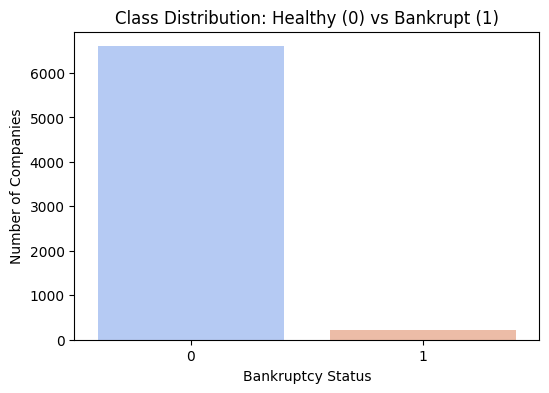


--- Top 5 Positive Correlations (Risk Factors) ---
Bankrupt                               1.000000
Debt ratio %                           0.250161
Current Liability to Assets            0.194494
Borrowing dependency                   0.176543
Current Liability to Current Assets    0.171306
Liability to Equity                    0.166812
Name: Bankrupt, dtype: float64

--- Top 5 Negative Correlations (Safety Factors) ---
ROA(C) before interest and depreciation before interest   -0.260807
ROA(B) before interest and depreciation after tax         -0.273051
ROA(A) before interest and % after tax                    -0.282941
Net Income to Total Assets                                -0.315457
Net Income Flag                                                 NaN
Name: Bankrupt, dtype: float64


In [3]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()
# Rename the target column to remove the '?' for easier coding
df.rename(columns={'Bankrupt?': 'Bankrupt'}, inplace=True)


# Check for Missing Values (NaN)
missing_values = df.isnull().sum().sum()
print(f"Total Missing Values in Dataset: {missing_values}") 

# Analyze Class Imbalance 
print("\n--- Class Distribution ---")
print(df['Bankrupt'].value_counts())
print("\n--- Percentage ---")
print(df['Bankrupt'].value_counts(normalize=True) * 100)

# Visualize the Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Bankrupt', data=df, palette='coolwarm')
plt.title('Class Distribution: Healthy (0) vs Bankrupt (1)')
plt.xlabel('Bankruptcy Status')
plt.ylabel('Number of Companies')
plt.show()

# Correlation Check (Top features)
# Let's see what correlates most with Bankruptcy
correlation = df.corr()['Bankrupt'].sort_values(ascending=False)
print("\n--- Top 5 Positive Correlations (Risk Factors) ---")
print(correlation.head(6)) # Top 5 + Bankrupt itself
print("\n--- Top 5 Negative Correlations (Safety Factors) ---")
print(correlation.tail(5))

### Data preprocessing and SMOTE

In [4]:
# Drop Useless Columns
# 'Net Income Flag' had NaN correlation, likely zero variance.
if 'Net Income Flag' in df.columns:
    df = df.drop('Net Income Flag', axis=1)
    print("Dropped 'Net Income Flag' column.")

#  Separate Features (X) and Target (y)
X = df.drop('Bankrupt', axis=1)
y = df['Bankrupt']

# Split Data (80% Train, 20% Test)
# stratify=y ensures we keep the same 97/3 ratio in the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original Training Shape: {X_train.shape}")
print(f"Original Test Shape:     {X_test.shape}")

# Scale the Data (StandardScaler)
# Financial ratios have different scales (e.g., 0.1 vs 10000). Scaling fixes this.
scaler = StandardScaler()

# FIT on training data only, then TRANSFORM both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE (Only on Training Data!)
# This generates fake "Bankrupt" samples to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\n--- After SMOTE ---")
print(f"Training Features Shape: {X_train_smote.shape}")
print(f"Training Target Distribution:\n{pd.Series(y_train_smote).value_counts()}")

Dropped 'Net Income Flag' column.
Original Training Shape: (5455, 94)
Original Test Shape:     (1364, 94)

--- After SMOTE ---
Training Features Shape: (10558, 94)
Training Target Distribution:
Bankrupt
0    5279
1    5279
Name: count, dtype: int64


### PCA and Visualization

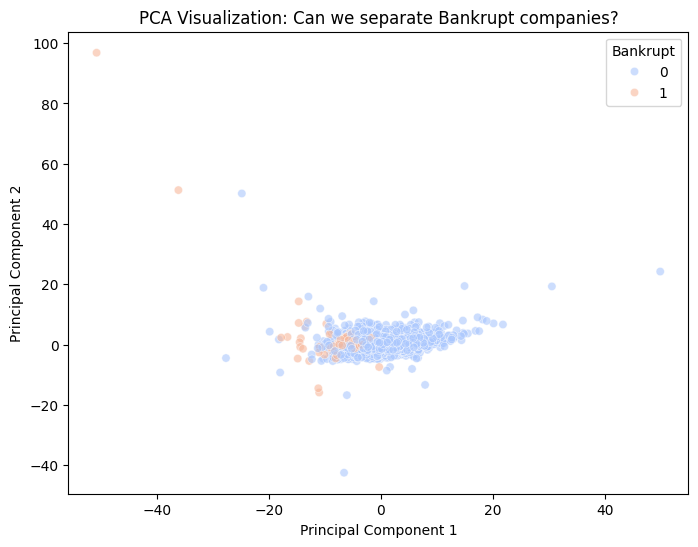

Explained Variance Ratio: [0.13675438 0.07380102]


In [5]:
# we can't use PCA to reduce dimensionlaity because of the problem in the Interpretability
from sklearn.decomposition import PCA

#  Apply PCA to reduce to 2 Dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

#  Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Bankrupt'] = y_train.reset_index(drop=True)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2', 
    hue='Bankrupt', 
    data=pca_df, 
    palette='coolwarm',
    alpha=0.6
)
plt.title('PCA Visualization: Can we separate Bankrupt companies?')
plt.show()

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

### Model Training and Evaluation

Training Logistic Regression...
Training Random Forest...

================ Logistic Regression Results ================
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1320
           1       0.19      0.80      0.30        44

    accuracy                           0.88      1364
   macro avg       0.59      0.84      0.62      1364
weighted avg       0.97      0.88      0.92      1364



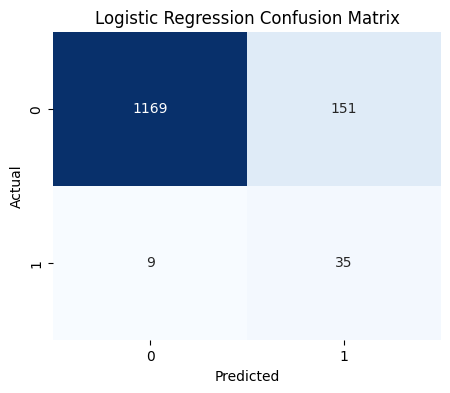


================ Random Forest Results ================
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.42      0.61      0.50        44

    accuracy                           0.96      1364
   macro avg       0.70      0.79      0.74      1364
weighted avg       0.97      0.96      0.96      1364



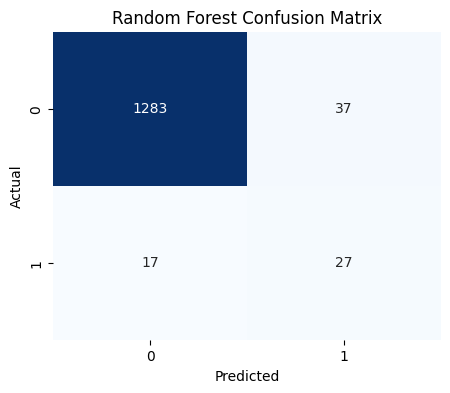

In [6]:
# --- Model A: Logistic Regression ---
print("Training Logistic Regression...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)

# Predict on Test Data
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# --- Model B: Random Forest  ---
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict on Test Data
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# --- Evaluation Function ---
def print_evaluation(model_name, y_test, y_pred):
    print(f"\n================ {model_name} Results ================")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display Results
print_evaluation("Logistic Regression", y_test, y_pred_log)
print_evaluation("Random Forest", y_test, y_pred_rf)